In [1]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
import pandas as pd
URM_path = "data_train.csv"
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep=",", 
                                # header=None, 
                                dtype={0:int, 1:int, 2:int},
                                engine='python')

URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction"]

In [2]:
import scipy.sparse as sps
import numpy as np

mapped_id, original_id = pd.factorize(URM_all_dataframe["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(URM_all_dataframe["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

URM_all_dataframe["UserID"] = URM_all_dataframe["UserID"].map(user_original_ID_to_index)
URM_all_dataframe["ItemID"] = URM_all_dataframe["ItemID"].map(item_original_ID_to_index)

In [3]:
n_users = len(URM_all_dataframe["UserID"].unique())
n_items = len(URM_all_dataframe["ItemID"].unique())

URM_all = sps.csr_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)),
                        shape = (n_users, n_items))

URM_all

<12638x22222 sparse matrix of type '<class 'numpy.int64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [4]:
from Data_manager.split_functions.split_train_validation_random_holdout import \
    split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

In [5]:
item_recommender = ItemKNNCFRecommender(URM_train=URM_validation)
item_recommender.load_model("result_experiments/", "ItemKNNCFRecommender_cosine_best_model.zip")

ItemKNNCFRecommender: URM Detected 2612 (20.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 5701 (25.7%) items with no interactions.
ItemKNNCFRecommender: Loading model from file 'result_experiments/ItemKNNCFRecommender_cosine_best_model.zip'
ItemKNNCFRecommender: Loading complete


In [6]:
slim_recommender = SLIMElasticNetRecommender(URM_train=URM_validation)
slim_recommender.load_model("result_experiments/", "SLIMElasticNetRecommender_best_model.zip")

SLIMElasticNetRecommender: URM Detected 2612 (20.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 5701 (25.7%) items with no interactions.
SLIMElasticNetRecommender: Loading model from file 'result_experiments/SLIMElasticNetRecommender_best_model.zip'
SLIMElasticNetRecommender: Loading complete


In [7]:
item_recommender.W_sparse

<22222x22222 sparse matrix of type '<class 'numpy.float32'>'
	with 6341383 stored elements in Compressed Sparse Row format>

In [8]:
slim_recommender.W_sparse

<22222x22222 sparse matrix of type '<class 'numpy.float32'>'
	with 389501 stored elements in Compressed Sparse Row format>

EvaluatorHoldout: Ignoring 2166 (17.1%) Users that have less than 1 test interactions
ItemKNNCustomSimilarityRecommender: URM Detected 441 ( 3.5%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 357 ( 1.6%) items with no interactions.
EvaluatorHoldout: Processed 10472 (100.0%) in 4.82 sec. Users per second: 2175
ItemKNNCustomSimilarityRecommender: URM Detected 441 ( 3.5%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 357 ( 1.6%) items with no interactions.
EvaluatorHoldout: Processed 10472 (100.0%) in 4.59 sec. Users per second: 2282
ItemKNNCustomSimilarityRecommender: URM Detected 441 ( 3.5%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 357 ( 1.6%) items with no interactions.
EvaluatorHoldout: Processed 10472 (100.0%) in 4.60 sec. Users per second: 2278
ItemKNNCustomSimilarityRecommender: URM Detected 441 ( 3.5%) users with no interactions.
ItemKNNCustomSimilarityRecommender: URM Detected 357 (

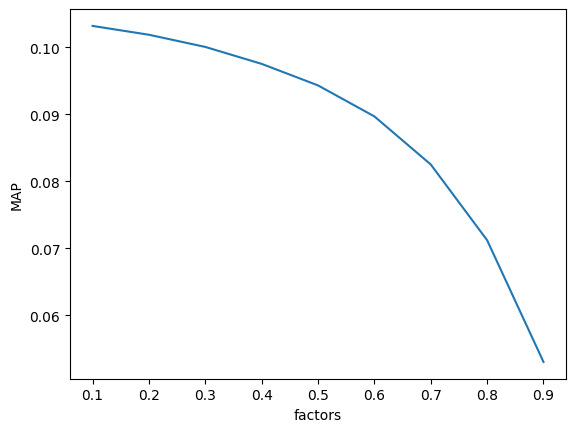

In [10]:
from Evaluation.Evaluator import EvaluatorHoldout
import matplotlib.pyplot as pyplot
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
evaluator_validation = EvaluatorHoldout(URM_test, cutoff_list=[10])

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
MAP_per_factors = []

for alpha in alphas:
    new_similarity = (1 - alpha) * item_recommender.W_sparse + alpha * slim_recommender.W_sparse
    recommender = ItemKNNCustomSimilarityRecommender(URM_train)
    recommender.fit(new_similarity)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_factors.append(result_df.loc[10]["MAP"])

pyplot.plot(alphas, MAP_per_factors)
pyplot.ylabel('MAP')
pyplot.xlabel('factors')
pyplot.show()

In [7]:
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython

recommender = MatrixFactorization_BPR_Cython(URM_all)
recommender.load_model("result_experiments/", "MatrixFactorization_BPR_Cython_Recommender_best_model.zip")

MatrixFactorization_BPR_Cython_Recommender: Loading model from file 'result_experiments/MatrixFactorization_BPR_Cython_Recommender_best_model.zip'
MatrixFactorization_BPR_Cython_Recommender: Loading complete


In [13]:
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
recommender = PureSVDRecommender(URM_train=URM_all)
recommender.load_model("result_experiments/", "PureSVDRecommender_best_model.zip")

PureSVDRecommender: Loading model from file 'result_experiments/PureSVDRecommender_best_model.zip'
PureSVDRecommender: Loading complete


In [8]:
from Recommenders.NonPersonalizedRecommender import TopPop
top_recommender = TopPop(URM_all)
top_recommender.fit()

In [9]:
URM_path = "data_target_users_test.csv"
URM_all_submission_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep=",", 
                                # header=None, 
                                dtype={0:int},
                                engine='python')

URM_all_submission_dataframe.columns = ["UserID"]

In [10]:
URM_all_submission_dataframe["UserIDMapped"] = URM_all_submission_dataframe["UserID"].map(user_original_ID_to_index)
# First, create a mask for non-null 'UserIDMapped' values
mask = ~URM_all_submission_dataframe['UserIDMapped'].isna()
URM_all_submission_dataframe['item_list'] = top_recommender.recommend(URM_all_submission_dataframe['UserIDMapped'], cutoff=10, remove_seen_flag=False)
URM_all_submission_dataframe.loc[mask, 'item_list'] = pd.Series(recommender.recommend(URM_all_submission_dataframe.loc[mask, 'UserIDMapped'].to_numpy().astype(int), cutoff=10, remove_seen_flag=True), index=URM_all_submission_dataframe.index[mask])

In [11]:
item_index_to_original_id = item_original_ID_to_index.reset_index().set_index(0).to_numpy().reshape(-1)
URM_all_submission_dataframe['item_list'] = URM_all_submission_dataframe['item_list'].apply(lambda item_indices: [item_index_to_original_id[index] for index in item_indices])

In [12]:
submission = URM_all_submission_dataframe[["UserID","item_list"]]
submission.columns = ["user_id", "item_list"]
submission['item_list'] = submission['item_list'].apply(lambda x: ' '.join(map(str, x))) # remove brakets

# Convert item_list to string format
submission['item_list'] = submission['item_list'].astype(str)

# Save to CSV without quotes and with the desired format
# submission.to_csv("submission.csv", index=False, header=["user_id", "item_list"], quoting=csv.QUOTE_NONE, sep=',')
def write_csv_without_quotes(df, file_path):
    with open(file_path, 'w', newline='') as f:
        f.write("user_id,item_list\n")
        for index, row in df.iterrows():
            f.write(f"{row['user_id']},{row['item_list']}\n")

# Save the DataFrame to CSV without quotes and with the desired format
write_csv_without_quotes(submission, "submission.csv")

/tmp/ipykernel_61242/2149847291.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['item_list'] = submission['item_list'].apply(lambda x: ' '.join(map(str, x))) # remove brakets
/tmp/ipykernel_61242/2149847291.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['item_list'] = submission['item_list'].astype(str)
